# Reading and plotting APR3 data

In [1]:
import datetime
import glob

# trick to read function in a separate file
import sys

import numpy as np
import pandas as pd
import xarray as xr

sys.path.append("/glade/u/home/rberrios/python/PRECIP/")
#matplotlib inline
import matplotlib.pyplot as plt
from defineColormaps import *

# increase font size
plt.rcParams.update({"font.size": 14})

# read functions to do ECCO-V classification
sys.path.append("/glade/u/home/rberrios/projects/cpex-cv/ecco-v/ecco-v_functions/")
from f_classSub import *
from f_classBasic import *
from f_reflTexture import *
from skimage.morphology import remove_small_objects, binary_opening, disk

Set some parameters for reading in the data.

In [2]:
# Low resolution ('lores') radar variables in APR hdf files ('hires' for w_band)
ku_band = "zhh14"  # Ku-band reflectivity
ka_band = "zhh35"  # Ka-band reflectivity
ku_vel = "vel14c"  # Mean Doppler Velocity dealiased and from Ku&Ka band
w_band = "z95n"  # W-band reflectivity, nadir channel

Set parameters for ecco-v

In [3]:
# Estimates of the melting layer and divergence level. These are used to
# make the subclassification into shallow, mid, deep, etc.
meltAlt=4.7; # Estimated altitude of melting layer in km
divAlt=8; # Estimated altitude of divergence level in km

## Tuning parameters

# These tuning parameters affect the boundaries between the
# convective/mixed/stratiform classifications
pixRadDBZ=5; # Horizontal number of pixels over which reflectivity texture is calculated.
# Lower values tend to lead to more stratiform precipitation.
upperLimDBZ=30; # This affects how reflectivity texture translates into convectivity.
# Higher values lead to more stratiform precipitation.
stratMixed=0.4; # Convectivity boundary between strat and mixed.
mixedConv=0.5; # Convectivity boundary between mixed and conv.

dbzBase=0; # Reflectivity base value which is subtracted from DBZ.
# Suggested values are: 0 dBZ for S, C, X, and Ku-band;
# -10 dBZ for Ka-band; -20 dBZ for W-band

# These tuning parameter enlarge mixed and convective regions, join them
# together and fill small holes
enlargeMixed=4; # Enlarges and joins mixed regions
enlargeConv=3; # Enlarges aned joins convective regions

# Echo below the altitude below is removed before processing starts
# to limit the effect of ocean clutter
surfAltLim=750; # ASL in m

# Remove "speckles". Removes contiguous radar echoes with less than speckNum
# pixels. (To remove noise in clear air.)
speckNum=10;

firstGate=1; # First range gate with good data

Set the time periods to be plotted.

In [79]:
file_date = "20220914"  # which date to create the APR plot for
start_time0 = "20220914,135200"  # start date,time for the APR plot
end_time0 = "20220914,141700"  # end date,time for the APR plot

uMotion = -20.1
vMotion = 0.0

Read navigation data.

In [80]:
# Function to convert seconds since midnight to datetime
def seconds_to_datetime(seconds):
    return base_date + datetime.timedelta(seconds=seconds)


# Define the date for which the seconds are counted
base_date = datetime.datetime(
    int(file_date[0:4]), int(file_date[4:6]), int(file_date[6:8])
)

# Read nav data
navFile = (
    "/glade/derecho/scratch/rberrios/projects/ongoing/cpex-cv/dataDC-8/CPEXCV-MetNav_DC8_%s_R0.ict"
    % file_date
)
dfNav = pd.read_csv(navFile, skiprows=75)

# Apply the function to the 'start_time' column to create a new 'start_datetime' column
dfNav["time_datetime"] = dfNav["Time_Start"].apply(seconds_to_datetime)

In [81]:
start_time = datetime.datetime.strptime(start_time0, "%Y%m%d,%H%M%S")
end_time = datetime.datetime.strptime(end_time0, "%Y%m%d,%H%M%S")

# locations of the APR folder/files
pth = "/glade/derecho/scratch/rberrios/projects/ongoing/cpex-cv/dataDC-8/"
apr_folder = pth + "cpexcv-APR3_DC8_" + file_date + "_R0"

# location of final Dropsonde CSVs
drop_folder = "./CPEXCV-dropsonde_DC8_" + file_date + "_R0/"

# location of HAMSR file
hamsr_folder = pth + "HAMSR/"

In [82]:
# Calculate the length of the segment in time, to scale out the figure
segDuration = int((end_time - start_time).total_seconds())
figWidth = int(segDuration / 240)
figWidth

6

Find the APR files.

In [83]:
import os

# find the starting APR file in apr_folder
first_file_index = None
for i, x in enumerate(
    sorted(os.listdir(apr_folder))
):  # sorted() makes sure the code goes through the files in alphabetical (chronological) order
    file_start_time = datetime.datetime.strptime(x[29:37] + x[38:43], "%Y%m%d%H%M%S")
    file_end_time = datetime.datetime.strptime(x[46:54] + x[55:60], "%Y%m%d%H%M%S")

    if (
        start_time <= file_start_time
    ):  # if start_time is before the APR file start time and not within any previous APR file's time ranges
        first_file_index = i
        break
    elif (start_time >= file_start_time) and (start_time < file_end_time):
        first_file_index = i
        break
    else:
        continue
if first_file_index == None:
    sys.exit("Requested start_time is beyond all available APR files")

# find the ending APR file in apr_folder
last_file_index = None
for i, x in enumerate(
    sorted(os.listdir(apr_folder))
):  # sorted() makes sure the code goes through the files in alphabetical (chronological) order
    file_start_time = datetime.datetime.strptime(x[29:37] + x[38:43], "%Y%m%d%H%M%S")
    file_end_time = datetime.datetime.strptime(x[46:54] + x[55:60], "%Y%m%d%H%M%S")

    if (
        end_time <= file_start_time
    ):  # if start_time is before the APR file start time and not within any previous APR file's time ranges
        last_file_index = i - 1
        break
    elif (end_time > file_start_time) and (end_time <= file_end_time):
        last_file_index = i
        break
    else:
        continue
if last_file_index == None:  # the end_time is after all available APR files
    last_file_index = (
        len(sorted(os.listdir(apr_folder))) - 1
    )  # the last available APR file's index
if last_file_index == -1:
    sys.exit("Requested end_time is before all available APR files")

apr_file_list = sorted(os.listdir(apr_folder))[first_file_index : last_file_index + 1]

apr_file_list

['cpexcv-APR3_DC8_20220914_R0_S20220914a134926_E20220914a135535_KUsKAsWns.nc',
 'cpexcv-APR3_DC8_20220914_R0_S20220914a135536_E20220914a140145_KUsKAsWns.nc',
 'cpexcv-APR3_DC8_20220914_R0_S20220914a140146_E20220914a140756_KUsKAsWns.nc',
 'cpexcv-APR3_DC8_20220914_R0_S20220914a140756_E20220914a141406_KUsKAsWns.nc',
 'cpexcv-APR3_DC8_20220914_R0_S20220914a141406_E20220914a142016_KUsKAsWns.nc']

In [84]:
apr_file_list

['cpexcv-APR3_DC8_20220914_R0_S20220914a134926_E20220914a135535_KUsKAsWns.nc',
 'cpexcv-APR3_DC8_20220914_R0_S20220914a135536_E20220914a140145_KUsKAsWns.nc',
 'cpexcv-APR3_DC8_20220914_R0_S20220914a140146_E20220914a140756_KUsKAsWns.nc',
 'cpexcv-APR3_DC8_20220914_R0_S20220914a140756_E20220914a141406_KUsKAsWns.nc',
 'cpexcv-APR3_DC8_20220914_R0_S20220914a141406_E20220914a142016_KUsKAsWns.nc']

Do the same for the dropsondes

In [85]:
# find the starting dropsonde file in drop_folder
drop_files = [
    f for f in sorted(glob.glob(drop_folder + "/CPEXCV-dropsonde*ict", recursive=True))
]
first_file_index = None
for i, x in enumerate(
    drop_files
):  # sorted() makes sure the code goes through the files in alphabetical (chronological) order
    file_start_time = datetime.datetime.strptime(x[56:70], "%Y%m%d%H%M%S")
    file_end_time = file_start_time  # hack; dropsonde start and final time assumed to be the same for simplicity

    if (
        start_time <= file_start_time
    ):  # if start_time is before the APR file start time and not within any previous APR file's time ranges
        first_file_index = i
        break
    elif start_time >= file_start_time and (start_time < file_end_time):
        first_file_index = i
        break
    else:
        continue
if first_file_index == None:
    sys.exit("Requested start_time is beyond all available APR files")

# find the ending APR file in apr_folder
last_file_index = None
for i, x in enumerate(
    drop_files
):  # sorted() makes sure the code goes through the files in alphabetical (chronological) order
    file_start_time = datetime.datetime.strptime(x[56:70], "%Y%m%d%H%M%S")
    file_end_time = file_start_time  # hack; dropsonde start and final time assumed to be the same for simplicity

    if (
        end_time <= file_start_time
    ):  # if start_time is before the APR file start time and not within any previous APR file's time ranges
        last_file_index = i - 1
        break
    elif (end_time > file_start_time) and (end_time <= file_end_time):
        last_file_index = i
        break
    else:
        continue
if last_file_index == None:  # the end_time is after all available APR files
    last_file_index = (
        len(sorted(os.listdir(apr_folder))) - 1
    )  # the last available APR file's index
if last_file_index == -1:
    sys.exit("Requested end_time is before all available APR files")

# [f for f in sorted(glob.glob(drop_folder+'/CPEXCV-dropsonde*ict', recursive=True))]
drop_file_list = drop_files[first_file_index : last_file_index + 1]
drop_file_list

['./CPEXCV-dropsonde_DC8_20220914_R0/CPEXCV-dropsonde_DC8_20220914135257_R0.ict']

Get list of HAMSR files.

In [86]:
# find the files in the hamsr folder
hamsr_files = [
    f
    for f in sorted(
        glob.glob(hamsr_folder + "/CPEXCV-HAMSR-data_DC8_*nc", recursive=True)
    )
]
first_file_index = None
for i, x in enumerate(
    hamsr_files
):  # sorted() makes sure the code goes through the files in alphabetical (chronological) order
    file_start_time = datetime.datetime.strptime(x[94:104], "%Y%m%d%H")
    file_end_time = datetime.datetime.strptime(x[94:104] + "59", "%Y%m%d%H%M")

    if (
        start_time <= file_start_time
    ):  # if start_time is before the APR file start time and not within any previous APR file's time ranges
        first_file_index = i
        break
    elif start_time >= file_start_time and (start_time < file_end_time):
        first_file_index = i
        break
    else:
        continue
if first_file_index == None:
    sys.exit("Requested start_time is beyond all available APR files")

# find the ending APR file in apr_folder
last_file_index = None
for i, x in enumerate(
    hamsr_files
):  # sorted() makes sure the code goes through the files in alphabetical (chronological) order
    file_start_time = datetime.datetime.strptime(x[94:104], "%Y%m%d%H")
    file_end_time = datetime.datetime.strptime(x[94:104] + "59", "%Y%m%d%H%M")

    if (
        end_time <= file_start_time
    ):  # if start_time is before the APR file start time and not within any previous APR file's time ranges
        last_file_index = i - 1
        break
    elif (end_time > file_start_time) and (end_time <= file_end_time):
        last_file_index = i
        break
    else:
        continue
if last_file_index == None:  # the end_time is after all available APR files
    last_file_index = (
        len(sorted(os.listdir(apr_folder))) - 1
    )  # the last available APR file's index
if last_file_index == -1:
    sys.exit("Requested end_time is before all available APR files")

# [f for f in sorted(glob.glob(drop_folder+'/CPEXCV-dropsonde*ict', recursive=True))]
hamsr_file_list = hamsr_files[first_file_index : last_file_index + 1]
hamsr_file_list

['/glade/derecho/scratch/rberrios/projects/ongoing/cpex-cv/dataDC-8/HAMSR/CPEXCV-HAMSR-data_DC8_2022091413_R1.nc',
 '/glade/derecho/scratch/rberrios/projects/ongoing/cpex-cv/dataDC-8/HAMSR/CPEXCV-HAMSR-data_DC8_2022091414_R1.nc']

Plot basic map of the flight just to be sure.

15778   -17.586268
15779   -17.587339
15780   -17.588402
15781   -17.589457
15782   -17.590506
           ...    
17274   -19.190275
17275   -19.191503
17276   -19.192730
17277   -19.193955
17278   -19.195181
Name: Longitude, Length: 1501, dtype: float64


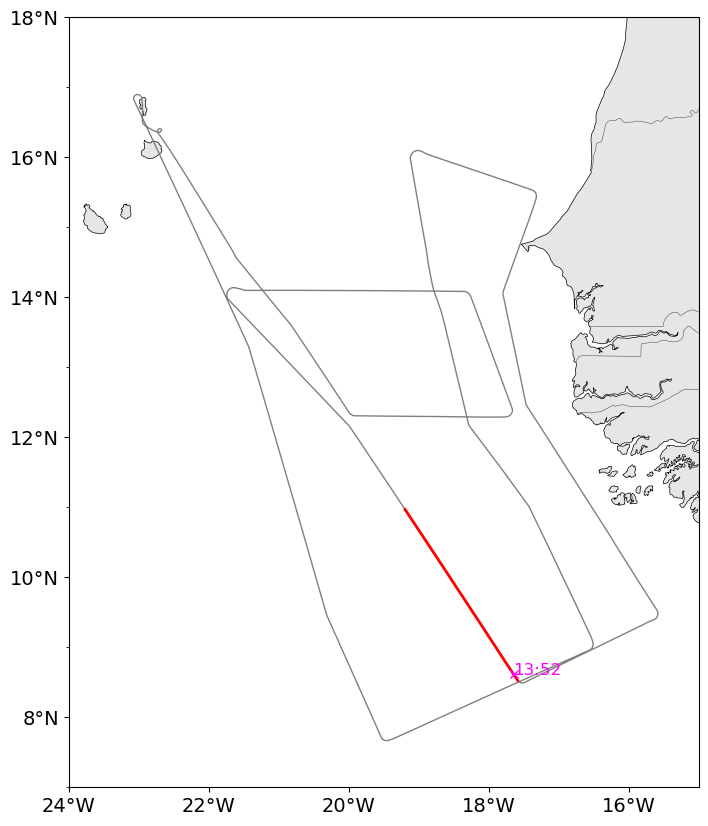

In [87]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter

# Create a figure and axis using the Plate Carree projection
fig, ax = plt.subplots(
    subplot_kw={"projection": ccrs.PlateCarree(central_longitude=0)}, figsize=[15, 10]
)

# Add coastlines and country borders
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.25)
ax.add_feature(cfeature.LAND, facecolor="0.90")

# Set the x and y axis limits
minLat = 7
maxLat = 18
minLon = -24
maxLon = -15
lat_interval = 2.0
lon_interval = 2.0
ax.set_extent([minLon, maxLon, minLat, maxLat], ccrs.PlateCarree())

# Add Latitudes
ax.set_yticks(np.arange(minLat, maxLat, lat_interval), ccrs.PlateCarree())
lat_formatter = LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

# Add Longitudes
ax.set_xticks(np.arange(minLon, maxLon, lon_interval), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
ax.xaxis.set_major_formatter(lon_formatter)

# plot the entire flack track
ax.plot(dfNav.Longitude, dfNav.Latitude, color="gray", linewidth=1)


# plot the segment of this plot
dfNavSub = dfNav[
    (dfNav.time_datetime >= start_time) & (dfNav.time_datetime <= end_time)
]
# lat=[]
# lon=[]
# for fname in apr_file_list:
#     print(fname)
#     lat.extend(xr.open_dataset(apr_folder+'/'+fname).lat.squeeze())
#     lon.extend(xr.open_dataset(apr_folder+'/'+fname).lon.squeeze())

print(dfNavSub.Longitude)
ax.plot(dfNavSub.Longitude, dfNavSub.Latitude, color="red", linewidth=2)

# add locations of dropsondes at this time
for fname in drop_file_list:
    # define label for this dropsonde
    label = fname[64:66] + ":" + fname[66:68]

    # read dropsonde data as a data frame
    df = pd.read_csv(fname, skiprows=123)

    # eliminate points where there's no temp and no dew point
    df = df[
        (df.Temperature != -9999.0)
        & (df.Dewpoint != -9999.0)
        & (df.Pressure >= 100.0)
        & (df.Latitude != -9999.0)
    ]

    ax.plot(df.Longitude.iloc[0], df.Latitude.iloc[0], "x", color="magenta")
    ax.text(
        df.Longitude.iloc[0], df.Latitude.iloc[0], label, fontsize=12, color="magenta"
    )

fOut = "./Figures/map_%s-%s.jpeg"% (start_time.strftime("%Y%m%d_%H%M"), end_time.strftime("%Y%m%d_%H%M"))
plt.savefig(
    fOut, bbox_inches="tight", dpi=150
)

Create function that reads height-time APR3 curtains.

In [88]:
def read_apr3_curtain_height_time(fname, varName, despeckle=True, speckNum=10):
    ds = xr.open_dataset(apr_folder + "/" + fname)

    # read time and altitude
    time = ds.lores_scantime[:]
    alt3d = ds.lores_alt3D[:]

    # Convert 'lo-res' APR times to datetimes
    time_dates = np.empty(time.shape, dtype=object)
    for i in np.arange(0, time.shape[0]):
        for j in np.arange(0, time.shape[1]):
            # tmp = datetime.datetime(time[i,j])
            tmp = datetime.datetime.utcfromtimestamp(time[i, j].values.item())
            time_dates[i, j] = tmp

    # Create a time at each gate (assuming it is the same down each ray, there is a better way to do this)
    time_gate = np.empty(alt3d.shape, dtype=object)
    for k in np.arange(0, alt3d.shape[0]):
        for i in np.arange(0, time_dates.shape[0]):
            for j in np.arange(0, time_dates.shape[1]):
                time_gate[i, j, k] = time_dates[i, j]

    time3d = np.copy(time_gate)

    # read reflectivity
    data = ds[varName].squeeze()
    dbz = ds["lores_"+ku_band].squeeze()

    [time2D, _] = np.meshgrid(time3d[:, 12, 0], alt3d[0, 12, :])
    print(time2D.shape)

    # plot the APR data factoring in the aircraft roll (ray adjustment)
    # choose the "pseudo-nadir" ray factoring in aircraft roll

    roll = ds["lores_roll"][:]
    ray_angles = np.linspace(
        -25, 25, 25
    )  # in degrees; 25 rays for each scan???  There were only 24 for CPEX (2017)...hmm
    dataNadir = np.empty(time2D.T.shape)
    altNadir = np.empty(time2D.T.shape)
    dbzNadir = np.empty(time2D.T.shape)
    elevation = np.empty(roll.shape[0])
    for scan in range(roll.shape[0]):
        ac_roll = np.mean(
            roll[scan, :]
        )  # roll varies slightly w/ray, so take the average roll value for a given scan and use that for ray adjustment
        ac_roll_scalar = ac_roll.values.item()  # Convert to a scalar
        diff_array = np.abs(ray_angles - ac_roll_scalar)
        ray_use = np.argmin(diff_array)  # get the index of minimum difference
        # determine scanning angle
        elevAll = ray_angles - ac_roll_scalar
        elevation[scan]=-90+np.fabs(elevAll[ray_use])
        altNadir[scan, :] = ds.lores_alt3D[scan, ray_use, :]
        if (ray_use == len(ray_angles)-1):
            print("we're on a turn")
            # we're turning
            dataNadir[scan, :] = np.nan
            dbzNadir[scan, :] = np.nan
        else:
            dataNadir[scan, :] = data[scan, ray_use, :]
            dbzNadir[scan, :] = dbz[scan, ray_use, :]

    # Remove data with dbz < 10 dBZ [the sensitivity of Ku; to be confirmed]
    dataNadir[dbzNadir < 10.0] = np.nan

    if (despeckle):
        # Create the initial binary mask
        maskSub = ~np.isnan(dataNadir)
    
        # --- New step: Apply morphological opening for despleckling ---
        # Create a structuring element. A disk is a good choice for meteorological data.
        # The radius of the disk is a key parameter to tune.
        structuring_element = disk(5) 
        
        # Apply the opening operation to the mask
        # This will remove small tendrils and bridges of noise.
        mask_opened = binary_opening(maskSub, footprint=structuring_element)
        
        # --- Your final steps, now on the cleaned mask ---
        # Optional but recommended: Remove any remaining small, isolated noise patches
        # that were not attached to the main clouds.
        mask_final = remove_small_objects(mask_opened, min_size=speckNum)
        
        # Apply the final, cleaned mask back to your original data
        dataNadir[mask_final == 0] = np.nan
    
        # # Remove speckles following LROSE/ECCO-V
        # maskSub = ~np.isnan(dataNadir)
        # maskSub = remove_small_objects(maskSub, min_size=speckNum)
        # dataNadir[maskSub == 0] = np.nan

    return dataNadir, altNadir, time2D, elevation

Create color map for ecco-v classifications.

In [89]:
from matplotlib.colors import LinearSegmentedColormap

# 1. Define your RGB colors as a list or NumPy array.
#    The values should be between 0 and 1.
colmapSC = np.array([
    [0, 0.1, 0.6],
    [0.32, 0.78, 0.59],
    [1, 0, 0],
    [1, 0, 1],
    [1, 1, 0],
    [0.99, 0.77, 0.22],
    [0.7, 0, 0]
])

# 2. Create the colormap object.
#    The first argument is the name you will use to call the colormap.
#    The second argument is your list of colors.
my_custom_cmap = LinearSegmentedColormap.from_list('my_custom_cmap', colmapSC)

# Optional: You can also register the colormap so you can call it by name string.
# plt.register_cmap(cmap=my_custom_cmap)

### Curtain plots - ku band plus classification

(656, 200)
we're on a turn
we're on a turn
we're on a turn
we're on a turn
we're on a turn
we're on a turn
we're on a turn
we're on a turn
we're on a turn
we're on a turn
we're on a turn
we're on a turn
we're on a turn
we're on a turn
we're on a turn
we're on a turn
we're on a turn
we're on a turn
we're on a turn
we're on a turn
we're on a turn
we're on a turn
we're on a turn
we're on a turn
(656, 200)
we're on a turn
we're on a turn
we're on a turn
we're on a turn
we're on a turn
we're on a turn
we're on a turn
we're on a turn
we're on a turn
we're on a turn
we're on a turn
we're on a turn
we're on a turn
we're on a turn
we're on a turn
we're on a turn
we're on a turn
we're on a turn
we're on a turn
we're on a turn
we're on a turn
we're on a turn
we're on a turn
we're on a turn
(656, 200)
we're on a turn
we're on a turn
we're on a turn
we're on a turn
we're on a turn
we're on a turn
we're on a turn
we're on a turn
we're on a turn
we're on a turn
we're on a turn
we're on a turn
we're o

/glade/u/home/rberrios/projects/cpex-cv/ecco-v/ecco-v_functions/f_reflTexture.py:136: RuntimeWarning: Mean of empty slice
  mean_dbzBlock = np.nanmean(dbzBlock, axis=1)
/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/glade/derecho/scratch/rberrios/tmp/ipykernel_14611/3845554793.py:62: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im0 = ax[0,0].pcolormesh(
/glade/derecho/scratch/rberrios/tmp/ipykernel_14611/3845554793.py:65: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case,

(656, 200)
(656, 200)
(656, 200)
-49.58091735839844 -29.939517974853516
Calculating reflectivity texture ...
Basic classification ...


/glade/u/home/rberrios/projects/cpex-cv/ecco-v/ecco-v_functions/f_reflTexture.py:136: RuntimeWarning: Mean of empty slice
  mean_dbzBlock = np.nanmean(dbzBlock, axis=1)
/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/glade/derecho/scratch/rberrios/tmp/ipykernel_14611/3845554793.py:62: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im0 = ax[0,0].pcolormesh(
/glade/derecho/scratch/rberrios/tmp/ipykernel_14611/3845554793.py:65: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case,

(656, 200)
(656, 200)
(656, 200)
-46.94742671224561 -23.58716928035586
Calculating reflectivity texture ...
Basic classification ...


/glade/u/home/rberrios/projects/cpex-cv/ecco-v/ecco-v_functions/f_reflTexture.py:136: RuntimeWarning: Mean of empty slice
  mean_dbzBlock = np.nanmean(dbzBlock, axis=1)
/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/glade/derecho/scratch/rberrios/tmp/ipykernel_14611/3845554793.py:62: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im0 = ax[0,0].pcolormesh(
/glade/derecho/scratch/rberrios/tmp/ipykernel_14611/3845554793.py:65: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case,

(656, 200)
(656, 200)
(656, 200)
-45.89591963337374 -21.33310800680702
Calculating reflectivity texture ...
Basic classification ...


/glade/u/home/rberrios/projects/cpex-cv/ecco-v/ecco-v_functions/f_reflTexture.py:136: RuntimeWarning: Mean of empty slice
  mean_dbzBlock = np.nanmean(dbzBlock, axis=1)
/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/glade/derecho/scratch/rberrios/tmp/ipykernel_14611/3845554793.py:62: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im0 = ax[0,0].pcolormesh(
/glade/derecho/scratch/rberrios/tmp/ipykernel_14611/3845554793.py:65: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case,

(656, 200)
(656, 200)
(656, 200)
-43.54928425250471 -24.485854180845273
Calculating reflectivity texture ...
Basic classification ...


/glade/u/home/rberrios/projects/cpex-cv/ecco-v/ecco-v_functions/f_reflTexture.py:136: RuntimeWarning: Mean of empty slice
  mean_dbzBlock = np.nanmean(dbzBlock, axis=1)
/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/glade/derecho/scratch/rberrios/tmp/ipykernel_14611/3845554793.py:62: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im0 = ax[0,0].pcolormesh(
/glade/derecho/scratch/rberrios/tmp/ipykernel_14611/3845554793.py:65: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case,

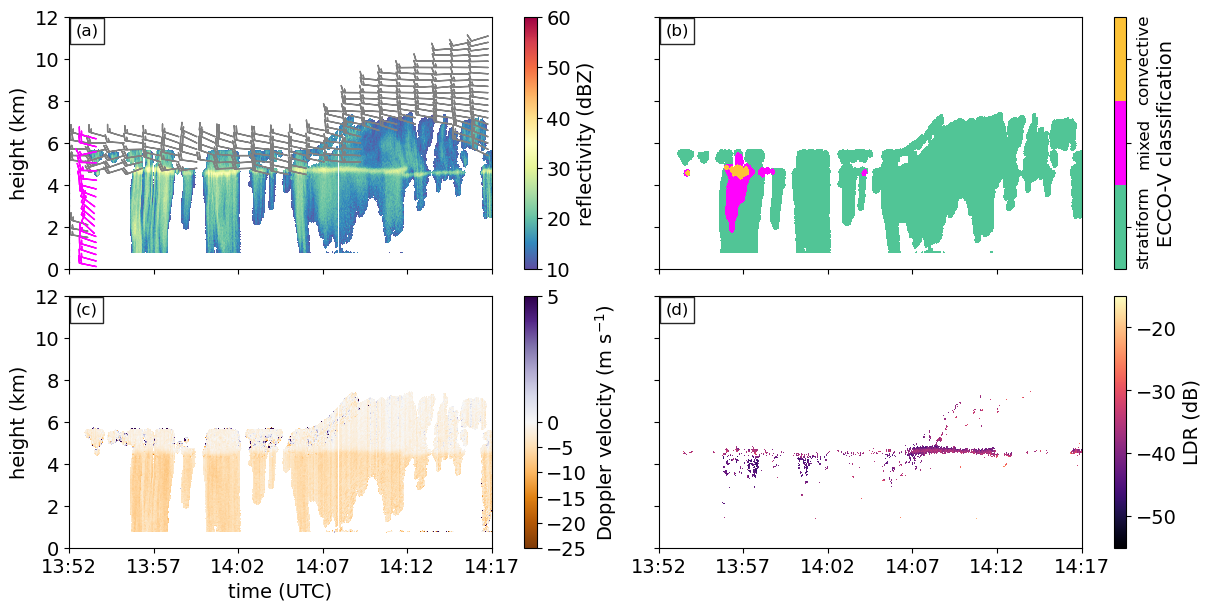

In [90]:
import matplotlib.dates as mdates
import matplotlib.colors as colors

# Create a TwoSlopeNorm instance
norm = colors.TwoSlopeNorm(vmin=-25, vcenter=0.0, vmax=5.0)

# Create custom color map for ECCO-V classification
# 1. Define your RGB colors as a list or NumPy array.
#    The values should be between 0 and 1.
colmapSC = np.array([
    [0, 0.1, 0.6],
    [0.32, 0.78, 0.59],
    [1, 0, 0],
    [1, 0, 1],
    [1, 1, 0],
    [0.99, 0.77, 0.22],
    [0.7, 0, 0]
])

# 2. Create the colormap object.
#    The first argument is the name you will use to call the colormap.
#    The second argument is your list of colors.
my_custom_cmap = colors.LinearSegmentedColormap.from_list('my_custom_cmap', colmapSC)

fig, ax = plt.subplots(figsize=(figWidth*2, 6), ncols=2, nrows=2, 
                       constrained_layout=True, sharex=True, sharey=True)
for fname in apr_file_list:
    if "KA" not in fname:
        continue
    velNadir, altNadir, time2D, _ = read_apr3_curtain_height_time(fname, "lores_" + ku_vel, speckNum=10)
    dbzNadir, altNadir, time2D, evelation = read_apr3_curtain_height_time(fname, "lores_"+ku_band, speckNum=10)
    ldrNadir, altNadir, time2D, evelation = read_apr3_curtain_height_time(fname, "lores_ldrhh14", despeckle=False)

    # # ecco-v classification
    # # get rid of data below 750 m
    velNadir[altNadir<750] = np.nan
    dbzNadir[altNadir<750] = np.nan
    ldrNadir[altNadir<750] = np.nan
    print(np.nanmin(ldrNadir),np.nanmax(ldrNadir))
    
    # Create a fake melting layer based on meltAlt
    MELTING_LAYER = dbzNadir.copy()
    MELTING_LAYER[:] = 20
    MELTING_LAYER[altNadir < meltAlt*1000.0] = 10

    # Create a fake temperature profile based on divAlt
    TEMP = dbzNadir.copy()
    TEMP[:] = -30
    TEMP[altNadir < divAlt*1000.0] = 10

    # %% Texture from reflectivity
    print('Calculating reflectivity texture ...')
    dbzText=f_reflTexture(dbzNadir.T,pixRadDBZ,dbzBase)

    # %% Convectivity
    convDBZ=(1.0/upperLimDBZ)*dbzText

    # # %% Basic classification
    print('Basic classification ...')
    classBasic=f_classBasic(convDBZ,stratMixed,mixedConv,MELTING_LAYER.T,enlargeMixed,enlargeConv)    

    im0 = ax[0,0].pcolormesh(
        time2D, altNadir.T * 1e-3, dbzNadir.T, cmap="Spectral_r", vmin=10, vmax=60
    )
    im1 = ax[1,0].pcolormesh(
        time2D, altNadir.T * 1e-3, velNadir.T, cmap="PuOr", norm=norm
    )

    im2 = ax[0,1].contourf(
        time2D, altNadir.T * 1e-3, classBasic, levels=[0.5,1.5,2.5,3.5], cmap=my_custom_cmap
    )

    im3 = ax[1,1].pcolormesh(
        time2D, altNadir.T * 1e-3, ldrNadir.T, cmap='magma', vmin=-55, vmax=-15
    )

cb0 = plt.colorbar(im0, ax=ax[0,0], pad=0.01)
cb0.set_label("reflectivity (dBZ)")
cb1 = plt.colorbar(im1, ax=ax[1,0], pad=0.01)
cb1.set_label("Doppler velocity (m s$^{-1}$)")
cb2 = plt.colorbar(im2, ax=ax[0,1], pad=0.01)
cb2.set_label("ECCO-V classification")
cb3 = plt.colorbar(im3, ax=ax[1,1], pad=0.01)
cb3.set_label("LDR (dB)")
ax[0,0].set_ylim([0, 12])
ax[1,0].set_xlabel("time (UTC)")
ax[0,0].set_ylabel("height (km)")
ax[1,0].set_ylabel("height (km)")
# ax[2].set_ylabel("height (km)")

# Set the ticks and corresponding labels
tick_locations = [1, 2, 3]
tick_labels = ['stratiform', 'mixed', 'convective']
cb2.set_ticks(tick_locations)
cb2.set_ticklabels(tick_labels, fontsize=12, rotation=90, va='center')

# Format the x-axis to display datetime objects
ax[-1,-1].xaxis_date()

# Define the interval for the x-axis tick labels (every 10 minutes)
ax[-1,-1].xaxis.set_major_locator(
    mdates.MinuteLocator(interval=5)
)  # Or mdates.SecondLocator(interval=600)

# Format the date/time display on the x-axis
date_format = mdates.DateFormatter("%H:%M")  # Display hours and minutes
ax[-1,-1].xaxis.set_major_formatter(date_format)

fig.autofmt_xdate()  # Rotate date labels for better readability

ax[-1,-1].set_xlim(start_time, end_time)

# now add DAWN data
fname = pth + "cpexcv-DAWN_DC8_20220914_R0.nc"
dawnData = xr.open_dataset(fname).sel(time=slice(start_time, end_time))

# subtract storm motion
dawnData['smoothed_U_comp']=dawnData['smoothed_U_comp']-uMotion
dawnData['smoothed_V_comp']=dawnData['smoothed_V_comp']-vMotion

[X, Y] = np.meshgrid(dawnData.time, dawnData.z)
ax[0,0].barbs(
    X[::10, ::2],
    Y[::10, ::2],
    dawnData.smoothed_U_comp.T[::10, ::2],
    dawnData.smoothed_V_comp.T[::10, ::2],
    length=5,
    barbcolor="gray",
)

for fname in drop_file_list:
    # read dropsonde data as a data frame
    df = pd.read_csv(fname, skiprows=123)

    # eliminate points where there's no temp and no dew point
    df = df[
        (df.Temperature != -9999.0) & (df.Dewpoint != -9999.0) & (df.Uwnd != -9999.0)
    ]
    # this is a trick to plot the dropsonde in place
    df["Time_Start_UTC"] = [
        pd.to_datetime("2022-09-14") + datetime.timedelta(seconds=df.Time_Start.iloc[0])
        for sec in df.Time_Start
    ]

    # subtract storm motion
    df['Uwnd'] = df['Uwnd']-uMotion
    df['Vwnd'] = df['Vwnd']-vMotion

    drop_skip = slice(None, None, 50)  # only plot every 100th value

    ax[0,0].barbs(
        pd.to_datetime(df["Time_Start_UTC"])[drop_skip],
        df["Altitude"][drop_skip] * 1e-3,
        df["Uwnd"][drop_skip],
        df["Vwnd"][drop_skip],
        fill_empty=True,
        length=5,
        pivot="middle",
        sizes=dict(emptybarb=0.075),
        barbcolor="magenta",
    )

check_time = datetime.datetime(2022, 9, 14, 12, 5)
for i,axis in enumerate(ax.flat):
    # add panel labels
    label = f"({chr(i+97)})"
    axis.text(0.015, 0.975, label,
        horizontalalignment='left',
        verticalalignment='top',
        transform=axis.transAxes,
        fontsize='12', bbox=dict(facecolor='white', alpha=0.85))

    # IF THIS IS THE CROSS SECTION AT THE TIME THE RADAR WAS RE-STARTED, ADD GRAY BOX
    if start_time <= check_time <= end_time:
        x = pd.date_range(start=datetime.datetime(2022, 9, 14, 12, 4, 32), end=datetime.datetime(2022, 9, 14, 12, 10, 42), freq='1s')
        axis.fill_between(x, 0, 12, color='gray', alpha=0.25)
        axis.text(datetime.datetime(2022, 9, 14, 12, 5, 45), 6, 'no data', fontsize=12, color='gray')


fOut = "./Figures/curtainPlot_%s-%s.jpeg"% (start_time.strftime("%Y%m%d_%H%M"), end_time.strftime("%Y%m%d_%H%M"))
plt.savefig(
    fOut,
    bbox_inches="tight",
    dpi=300,
)

### Example using the subclassification

<xarray.DataArray 'lores_zhh14' ()> Size: 8B
array(85.23852567)
(656, 200)
Calculating reflectivity texture ...
Basic classification ...
Sub classification ...
Plotting ...


/glade/u/home/rberrios/projects/cpex-cv/ecco-v/ecco-v_functions/f_reflTexture.py:136: RuntimeWarning: Mean of empty slice
  mean_dbzBlock = np.nanmean(dbzBlock, axis=1)
/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/glade/derecho/scratch/rberrios/tmp/ipykernel_40059/4078170382.py:143: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im0 = ax[0].pcolormesh(


<xarray.DataArray 'lores_zhh14' ()> Size: 8B
array(90.35347483)
(656, 265)
Calculating reflectivity texture ...
Basic classification ...
Sub classification ...
Plotting ...


/glade/u/home/rberrios/projects/cpex-cv/ecco-v/ecco-v_functions/f_reflTexture.py:136: RuntimeWarning: Mean of empty slice
  mean_dbzBlock = np.nanmean(dbzBlock, axis=1)
/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/glade/derecho/scratch/rberrios/tmp/ipykernel_40059/4078170382.py:143: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im0 = ax[0].pcolormesh(


<xarray.DataArray 'lores_zhh14' ()> Size: 8B
array(87.59297804)
(656, 200)
Calculating reflectivity texture ...
Basic classification ...
here2
Sub classification ...
Plotting ...


/glade/u/home/rberrios/projects/cpex-cv/ecco-v/ecco-v_functions/f_reflTexture.py:136: RuntimeWarning: Mean of empty slice
  mean_dbzBlock = np.nanmean(dbzBlock, axis=1)
/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/glade/derecho/scratch/rberrios/tmp/ipykernel_40059/4078170382.py:143: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im0 = ax[0].pcolormesh(


<xarray.DataArray 'lores_zhh14' ()> Size: 8B
array(85.07613234)
(656, 200)
Calculating reflectivity texture ...
Basic classification ...


/glade/u/home/rberrios/projects/cpex-cv/ecco-v/ecco-v_functions/f_reflTexture.py:136: RuntimeWarning: Mean of empty slice
  mean_dbzBlock = np.nanmean(dbzBlock, axis=1)
/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Sub classification ...
Plotting ...


/glade/derecho/scratch/rberrios/tmp/ipykernel_40059/4078170382.py:143: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im0 = ax[0].pcolormesh(


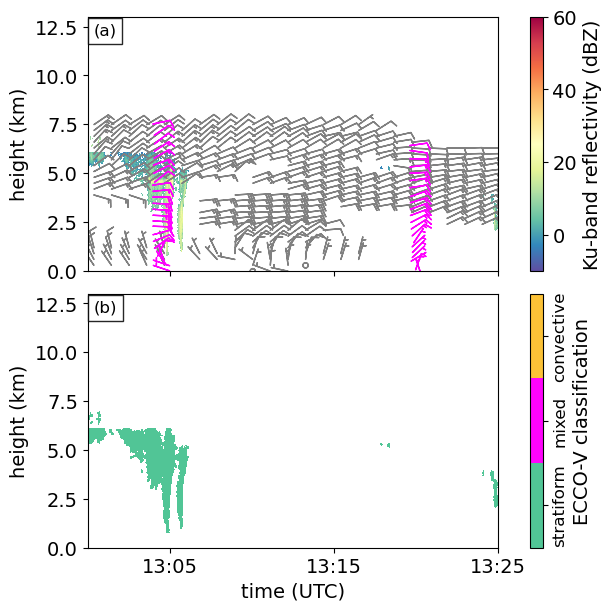

In [108]:
import matplotlib.dates as mdates
from skimage.morphology import remove_small_objects

# define colormap and contour levels
cmap = defineColormap("refl10cm_1km")
levels = np.arange(5, 80, 5)

nrows = 2

fig, ax = plt.subplots(figsize=(figWidth, 3*nrows), ncols=1, nrows=nrows, constrained_layout=True, sharey=True, sharex=True)
for fname in apr_file_list:
    if "KA" not in fname:
        continue
    ds = xr.open_dataset(apr_folder + "/" + fname)

    # read time and altitude
    time = ds.lores_scantime[:]
    alt3d = ds.lores_alt3D[:]

    # Convert 'lo-res' APR times to datetimes
    time_dates = np.empty(time.shape, dtype=object)
    for i in np.arange(0, time.shape[0]):
        for j in np.arange(0, time.shape[1]):
            # tmp = datetime.datetime(time[i,j])
            tmp = datetime.datetime.utcfromtimestamp(time[i, j].values.item())
            time_dates[i, j] = tmp

    # Create a time at each gate (assuming it is the same down each ray, there is a better way to do this)
    time_gate = np.empty(alt3d.shape, dtype=object)
    for k in np.arange(0, alt3d.shape[0]):
        for i in np.arange(0, time_dates.shape[0]):
            for j in np.arange(0, time_dates.shape[1]):
                time_gate[i, j, k] = time_dates[i, j]

    time3d = np.copy(time_gate)

    # read reflectivity
    dbz = ds["lores_" + ku_band].squeeze()

    print(dbz[:, 12, :].max())
    # dbz = dbz.where(z>0)

    [time2D, _] = np.meshgrid(time3d[:, 12, 0], alt3d[0, 12, :])
    print(time2D.shape)

    # plot the APR data factoring in the aircraft roll (ray adjustment)
    # choose the "pseudo-nadir" ray factoring in aircraft roll

    roll = ds["lores_roll"][:]
    ray_angles = np.linspace(
        -25, 25, 25
    )  # in degrees; 25 rays for each scan
    dataNadir = xr.DataArray(np.empty(time2D.T.shape),dims=('N_time_lo','N_range_lo'))
    altNadir = xr.DataArray(np.empty(time2D.T.shape),dims=('N_time_lo','N_range_lo'))
    elevation = np.empty(roll.shape[0])
    for scan in range(roll.shape[0]):
        ac_roll = np.mean(
            roll[scan, :]
        )  # roll varies slightly w/ray, so take the average roll value for a given scan and use that for ray adjustment
        ac_roll_scalar = ac_roll.values.item()  # Convert to a scalar
        diff_array = np.abs(ray_angles - ac_roll_scalar)
        ray_use = np.argmin(diff_array)  # Now it will work correctly
        dataNadir[scan, :] = dbz[scan, ray_use, :]
        altNadir[scan, :] = ds.lores_alt3D[scan, ray_use, :]

        # determine scanning angle
        elevAll = ray_angles - ac_roll_scalar
        elevation[scan]=-90+np.fabs(elevAll[ray_use])

    # we've got the data, now we need to prepare the data for ecco

    # Remove surface echo below a certain altitude
    dataNadir = dataNadir.where(altNadir >= surfAltLim, other=np.nan)
    # data.DBZ(data.asl<surfAltLim]=nan;

    # Remove speckles
    maskSub = ~np.isnan(dataNadir)
    maskSub = remove_small_objects(maskSub.values, min_size=speckNum)
    ## maskSub=~isnan(data.DBZ);
    ## maskSub=bwareaopen(maskSub,speckNum);

    dataNadir = dataNadir.where(maskSub != 0, other=np.nan)
    # data.DBZ(maskSub==0]=nan;

    # Create a fake melting layer based on meltAlt
    MELTING_LAYER = dataNadir.copy()
    MELTING_LAYER[:] = 20
    MELTING_LAYER = MELTING_LAYER.where(altNadir >= meltAlt*1000.0, other=10)
    # data.MELTING_LAYER=nan(size(data.DBZ));
    # data.MELTING_LAYER(data.asl>=meltAlt.*1000]=20;
    # data.MELTING_LAYER(data.asl<meltAlt.*1000]=10;

    # Create a fake temperature profile based on divAlt
    TEMP = dataNadir.copy()
    TEMP[:] = -30
    TEMP = TEMP.where(altNadir>=divAlt*1000.0, other=10)
    # data.TEMP=nan(size(data.DBZ));
    # data.TEMP(data.asl>=divAlt.*1000]=-30;
    # data.TEMP(data.asl<divAlt.*1000]=10;

    # %% Texture from reflectivity

    print('Calculating reflectivity texture ...')

    dbzText=f_reflTexture(dataNadir.T,pixRadDBZ,dbzBase)

    # %% Convectivity
    # convDBZ = (1.0/upperLimDBZ)*dataNadir.values
    convDBZ=(1.0/upperLimDBZ)*dbzText

    # convDBZ=1/upperLimDBZ*dbzText

    # # %% Basic classification

    print('Basic classification ...')

    classBasic=f_classBasic(convDBZ,stratMixed,mixedConv,MELTING_LAYER.values.T,enlargeMixed,enlargeConv)

    # # %% Sub classification

    print('Sub classification ...')
    # dummy variable for terrain
    TOPO = np.zeros(dataNadir.shape)
    classSub=f_classSub(classBasic,altNadir.values.T,TOPO.T,MELTING_LAYER.values.T,TEMP.values.T,elevation,firstGate,surfAltLim)

    # % Change the default values of the subclassification to something that
    # % is easier to plot
    classSubPlot=classSub;
    classSubPlot[classSub==14]=1
    classSubPlot[classSub==16]=2
    classSubPlot[classSub==18]=3
    classSubPlot[classSub==25]=4
    classSubPlot[classSub==30]=5
    classSubPlot[classSub==32]=6
    classSubPlot[classSub==34]=7
    classSubPlot[classSub==36]=8
    classSubPlot[classSub==38]=9
    
    # %% Plot

    print('Plotting ...')
    
    im0 = ax[0].pcolormesh(
        time2D, altNadir.T * 1e-3, dataNadir.T, cmap="Spectral_r", vmin=-10, vmax=60
    )

    im1 = ax[1].contourf(
        time2D, altNadir.T * 1e-3, classBasic, levels=[0.5,1.5,2.5,3.5], cmap=my_custom_cmap
    )

cb0 = plt.colorbar(im0, ax=ax[0], pad=0.01)
cb0.set_label("Ku-band reflectivity (dBZ)")
cb1 = plt.colorbar(im1, ax=ax[1], pad=0.01)
cb1.set_label("ECCO-V classification")
ax[0].set_ylim([0, 13])
ax[1].set_xlabel("time (UTC)")
ax[0].set_ylabel("height (km)")
ax[1].set_ylabel("height (km)")

# Set the ticks and corresponding labels
tick_locations = [1, 2, 3]
tick_labels = ['stratiform', 'mixed', 'convective']
cb1.set_ticks(tick_locations)
cb1.set_ticklabels(tick_labels, fontsize=12, rotation=90, va='center')

# Format the x-axis to display datetime objects
ax[0].xaxis_date()

# Define the interval for the x-axis tick labels (every 10 minutes)
interval = datetime.timedelta(minutes=10)
ax[0].xaxis.set_major_locator(
    mdates.MinuteLocator(interval=10)
)  # Or mdates.SecondLocator(interval=600)

# Format the date/time display on the x-axis
date_format = mdates.DateFormatter("%H:%M")  # Display hours and minutes
ax[0].xaxis.set_major_formatter(date_format)

fig.autofmt_xdate()  # Rotate date labels for better readability

ax[0].set_xlim(start_time, end_time)

# now add DAWN data
fname = pth + "cpexcv-DAWN_DC8_20220914_R0.nc"
dawnData = xr.open_dataset(fname).sel(time=slice(start_time, end_time))
# dawnData = xr.open_dataset(fname).sel(time=slice('2022-09-14 10:47','2022-09-14 11:25'))

[X, Y] = np.meshgrid(dawnData.time, dawnData.z)
ax[0].barbs(
    X[::10, ::2],
    Y[::10, ::2],
    dawnData.smoothed_U_comp.T[::10, ::2],
    dawnData.smoothed_V_comp.T[::10, ::2],
    length=5,
    barbcolor="gray",
)

for fname in drop_file_list:
    # read dropsonde data as a data frame
    df = pd.read_csv(fname, skiprows=123)

    # eliminate points where there's no temp and no dew point
    df = df[
        (df.Temperature != -9999.0) & (df.Dewpoint != -9999.0) & (df.Uwnd != -9999.0)
    ]
    # this is a trick to plot the dropsonde in place
    df["Time_Start_UTC"] = [
        pd.to_datetime("2022-09-14") + datetime.timedelta(seconds=df.Time_Start.iloc[0])
        for sec in df.Time_Start
    ]

    drop_skip = slice(None, None, 50)  # only plot every 100th value

    ax[0].barbs(
        pd.to_datetime(df["Time_Start_UTC"])[drop_skip],
        df["Altitude"][drop_skip] * 1e-3,
        df["Uwnd"][drop_skip],
        df["Vwnd"][drop_skip],
        fill_empty=True,
        length=5,
        pivot="middle",
        sizes=dict(emptybarb=0.075),
        barbcolor="magenta",
    )

# add panel labels
for i,axis in enumerate(ax.flat):
    # add panel labels
    label = f"({chr(i+97)})"
    axis.text(0.015, 0.975, label,
        horizontalalignment='left',
        verticalalignment='top',
        transform=axis.transAxes,
        fontsize='12', bbox=dict(facecolor='white', alpha=0.85))

In [48]:
ds.variables

Frozen({'hi2lo_mask': <xarray.Variable (N_time_lo: 200, N_beams_XT: 25, N_range_lo: 656)> Size: 26MB
[3280000 values with dtype=float64]
Attributes:
    Name:         hi2lo_mask
    units:        1
    description:  Cloud mask: from W=band reflectivity only\n(5): radar trans..., 'hi2lo_alt3D': <xarray.Variable (N_time_lo: 200, N_beams_XT: 25, N_range_lo: 656)> Size: 26MB
[3280000 values with dtype=float64]
Attributes:
    Name:         hi2lo_alt3D
    units:        m
    description:  Altitude of each resolution bin. [hi2lo], 'hi2lo_lat3D': <xarray.Variable (N_time_lo: 200, N_beams_XT: 25, N_range_lo: 656)> Size: 26MB
[3280000 values with dtype=float64]
Attributes:
    Name:         hi2lo_lat3D
    units:        deg
    description:  Latitude of each resolution bin below the aircraft. [hi2lo], 'hi2lo_lon3D': <xarray.Variable (N_time_lo: 200, N_beams_XT: 25, N_range_lo: 656)> Size: 26MB
[3280000 values with dtype=float64]
Attributes:
    Name:         hi2lo_lon3D
    units:        deg
 